In [3]:
source("forecast_research/finance/markets_functions.R")
load_all("forecast_research/vendor/hmmTMB")
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB")
options(warn = -1)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB

Skipping install of 'hmmTMB' from a local remote, the SHA1 (1.1.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [1]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
library(tidyverse)
library(tibble)
library(grid)
library(DescTools)
library(rcompanion)

set.seed(1)
load_all("../vendor/hmmTMB")
source("markets_functions.R")  # adjust path if the notebook’s cwd differs

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', ex

ERROR: Error in library(tidyverse): there is no package called ‘tidyverse’


Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_Care_Index, Shipping_Futures



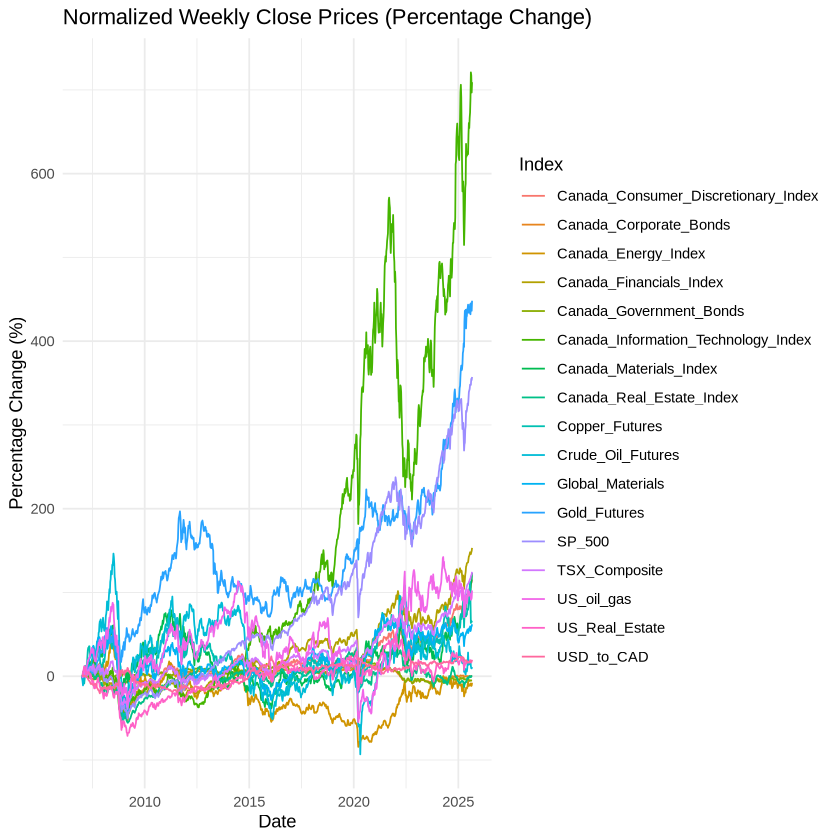

In [4]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )

close_data_log <- ln_transform(close_data)

In [5]:
close_data_log <- close_data_log %>%
  mutate(Date = close_data$Date)

write.csv(close_data_log, "close_data_log.csv", row.names = FALSE)

In [6]:
state_probs_df <- data.frame(Date = close_data$Date)
for (col in c("TSX_Composite", "Crude_Oil_Futures", "Gold_Futures", "Copper_Futures",  "SP_500")) {

  hmm_model <- fit_hmm(
    n_states = 3,
    data = close_data_log,
    obs_name = col,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = NULL
  )
  state_probs <- hmm_model$state_probs()
  colnames(state_probs) <- paste0(col, "_", 1:ncol(state_probs))
  state_probs_df <- cbind(state_probs_df, state_probs)
}
head(state_probs_df)

,Date,TSX_Composite_1,TSX_Composite_2,TSX_Composite_3,Crude_Oil_Futures_1,Crude_Oil_Futures_2,Crude_Oil_Futures_3,Gold_Futures_1,Gold_Futures_2,Gold_Futures_3,Copper_Futures_1,Copper_Futures_2,Copper_Futures_3,SP_500_1,SP_500_2,SP_500_3
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2007-01-05,5.253251e-08,2.100981e-06,0.9999978,4.619063e-18,1.0000000,3.658253e-12,2.045610e-14,3.228181e-37,1.0000000,1.278088e-13,1.0000000,1.005244e-11,4.927880e-11,2.314483e-09,1.0000000
2,2007-01-12,2.895812e-05,1.846662e-02,0.9815044,1.679716e-04,0.9845264,1.530565e-02,3.787989e-04,7.076093e-02,0.9288603,2.788600e-02,0.9712184,8.955819e-04,1.707702e-11,8.175088e-03,0.9918249
3,2007-01-19,2.121232e-05,2.036142e-02,0.9796174,1.207266e-04,0.9002960,9.958329e-02,7.718432e-04,8.126738e-01,0.1865544,2.836367e-02,0.9700557,1.580630e-03,2.344929e-06,1.433788e-02,0.9856598
4,2007-01-26,1.981915e-05,2.219093e-02,0.9777893,1.171468e-04,0.7181713,2.817115e-01,2.418136e-03,8.973101e-01,0.1002717,1.981055e-02,0.9784751,1.714351e-03,6.689544e-06,2.511054e-02,0.9748828
5,2007-02-02,1.914912e-05,2.283679e-02,0.9771441,7.509926e-05,0.5309054,4.690195e-01,3.235014e-03,8.200914e-01,0.1766736,2.835303e-02,0.9698878,1.759201e-03,1.757772e-05,3.819241e-02,0.9617900
6,2007-02-09,2.550554e-05,2.764322e-02,0.9723313,3.849903e-05,0.3432748,6.566867e-01,3.342686e-03,8.181962e-01,0.1784612,2.578777e-02,0.9729146,1.297623e-03,4.062184e-05,7.613352e-02,0.9238259


In [7]:
write.csv(state_probs_df, "state_probs_df.csv", row.names = FALSE)

In [8]:
tsx_state_probs <- hmm_model$state_probs()
colnames(tsx_state_probs) <- paste0("TSX_State_", 1:ncol(tsx_state_probs))
head(tsx_state_probs)

TSX_State_1,TSX_State_2,TSX_State_3
4.927880e-11,2.314483e-09,1.0000000
1.707702e-11,8.175088e-03,0.9918249
2.344929e-06,1.433788e-02,0.9856598
6.689544e-06,2.511054e-02,0.9748828
1.757772e-05,3.819241e-02,0.9617900
4.062184e-05,7.613352e-02,0.9238259


In [9]:
close_data

Date,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures,USD_to_CAD,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Real_Estate,SP_500
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2007-01-05,20.21277,26.80500,57.8175,622.775,2.690300,1.170620,20.1800,20.1650,45.73667,55.4600,76.7100,141.1933
2007-01-12,19.97872,26.49500,54.1240,614.020,2.589900,1.174380,20.1660,20.1400,45.36600,54.9580,77.7160,141.8400
2007-01-19,20.26596,26.71800,51.4800,629.825,2.524875,1.172840,20.1220,20.0800,46.09250,55.9475,80.3575,142.8350
2007-01-26,20.57396,26.89800,54.2380,643.680,2.587100,1.180780,20.1180,20.0740,47.81400,57.2220,81.4080,142.7040
2007-02-02,20.81763,27.02900,57.0880,648.580,2.518000,1.179820,20.1040,20.0380,49.09800,58.0000,83.5760,143.6020
2007-02-09,20.98278,27.32800,58.9860,656.460,2.455000,1.179900,20.1900,20.0900,49.08200,59.0120,85.8380,144.7820
2007-02-16,21.05572,27.31600,58.4500,666.000,2.582100,1.166920,20.1880,20.1120,48.80800,60.2920,85.1960,145.0500
2007-02-23,21.26393,27.56800,60.0575,674.950,2.707875,1.163090,20.2720,20.1860,49.48750,61.8450,85.3275,145.7975
2007-03-02,20.88349,27.20700,61.6560,668.720,2.764000,1.169340,20.3620,20.3240,49.02200,59.6640,81.1940,140.9560
